In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def read_csv_file(file_path):
    df = pd.read_csv(file_path)
    return df

# Example usage
csv_file_path = r'C:\Users\Romario Mason\OneDrive\Documents\GitHub\Portfolio_23\Forecasting\Product Demand Forecasting\Data\Historical Product Demand.csv'
data_frame = read_csv_file(csv_file_path)
print(data_frame.head())

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

   Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500 


# Data Exploration/Cleaning/Processing

In [10]:
def explore_dataframe(df):
    # Shape of the DataFrame
    print("Shape:", df.shape)
    print()

    # Columns in the DataFrame
    print("Columns:")
    print(df.columns)
    print()

    # Unique values in each non-date column
    print("Unique values (excluding date columns):")
    for column in df.columns:
        if df[column].dtype != 'datetime64[ns]':
            unique_values = df[column].unique()
            print(column, ":", unique_values)
    print()

    # Missing values
    print("Missing values:")
    print(df.isnull().sum())
    print()

    # Visualization of missing values
    with plt.style.context('fivethirtyeight'):
        plt.figure(figsize=(8, 6))
        sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
        plt.title("Missing Values")
        plt.show()


Shape: (1048575, 5)

Columns:
Index(['Product_Code', 'Warehouse', 'Product_Category', 'Date',
       'Order_Demand'],
      dtype='object')

Unique values (excluding date columns):
Product_Code : ['Product_0993' 'Product_0979' 'Product_1159' ... 'Product_0237'
 'Product_0644' 'Product_0853']
Warehouse : ['Whse_J' 'Whse_S' 'Whse_C' 'Whse_A']
Product_Category : ['Category_028' 'Category_006' 'Category_001' 'Category_019'
 'Category_005' 'Category_030' 'Category_032' 'Category_011'
 'Category_033' 'Category_007' 'Category_015' 'Category_021'
 'Category_024' 'Category_026' 'Category_023' 'Category_022'
 'Category_009' 'Category_003' 'Category_004' 'Category_018'
 'Category_020' 'Category_013' 'Category_008' 'Category_017'
 'Category_031' 'Category_025' 'Category_010' 'Category_029'
 'Category_012' 'Category_002' 'Category_014' 'Category_027'
 'Category_016']
Date : ['2012/7/27' '2012/1/19' '2012/2/3' ... '2016/4/17' '2016/3/27'
 '2016/2/21']
Order_Demand : ['100 ' '500 ' '50000 ' ... '(375

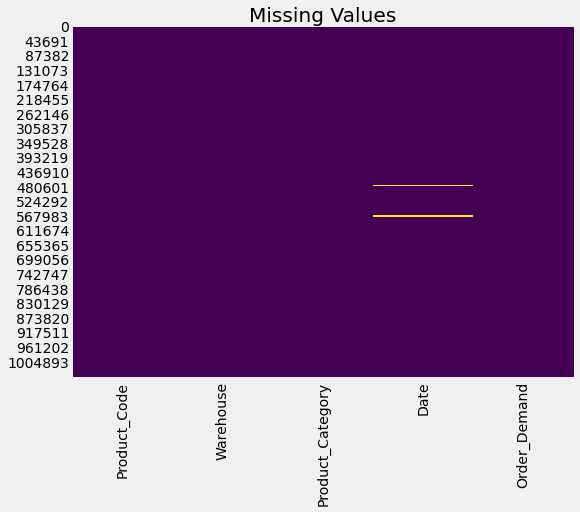

In [12]:
explore_dataframe(data_frame)

In [18]:
def clean_data(df):
    # Convert 'date' column to datetime type
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

    # Check and convert 'order_demand' column to integers
    if 'order_demand' in df.columns:
        df['order_demand'] = df['order_demand'].astype(str).str.replace('(','-').str.replace(')','').astype(int)

    # Describe the data
    print("Data description:")
    print(df.describe())

       # Display data types of each column
    print("Data types:")
    print(df.dtypes)
    print()

In [19]:
clean_data(data_frame)

Data description:
        Product_Code Warehouse Product_Category       Date Order_Demand
count        1048575   1048575          1048575    1037336      1048575
unique          2160         4               33       1729         3828
top     Product_1359    Whse_J     Category_019  2013/9/27        1000 
freq           16936    764447           481099       2075       112682
Data types:
Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object



In [20]:
df = data_frame.rename(columns = {'Product_Code': 'Code',
                    'Product_Category':'Category',
                    'Order_Demand':'Demand'})
df.head()

,Code,Warehouse,Category,Date,Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


In [21]:
def drop_missing_rows(df, column_name):
    if column_name in df.columns:
        missing_count = df[column_name].isnull().sum()
        total_count = len(df)
        missing_percentage = (missing_count / total_count) * 100

        if missing_percentage < 5:
            df.dropna(subset=[column_name], inplace=True)
            print(f"I have dropped {missing_count} rows because only {missing_percentage:.2f}% of the data is missing.")


In [22]:
drop_missing_rows(df, 'Date')

I have dropped 11239 rows because only 1.07% of the data is missing.


In [27]:
def convert_column_to_date(df, column_name):
    if column_name in df.columns:
        df[column_name] = pd.to_datetime(df[column_name])
        print(f"Column '{column_name}' converted to date type.")
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")

In [28]:
column_to_convert = 'Date'
convert_column_to_date(df, column_to_convert)

Column 'Date' converted to date type.


In [29]:
def check_min_max_dates(df, column_name):
    if column_name in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[column_name]):
            min_date = df[column_name].min()
            max_date = df[column_name].max()
            print(f"Column: {column_name}")
            print("Minimum date:", min_date)
            print("Maximum date:", max_date)
        else:
            print(f"Column '{column_name}' is not a date type.")
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")

In [30]:
column_to_check = 'Date'
check_min_max_dates(df, column_to_check)

Column: Date
Minimum date: 2011-01-08 00:00:00
Maximum date: 2017-01-09 00:00:00


In [32]:
date_column = 'Date'
if date_column in df.columns:
    if pd.api.types.is_datetime64_any_dtype(df[date_column]):
        df.set_index(date_column, inplace=True)
        print(f"Index set to '{date_column}'.")
    else:
        print(f"Column '{date_column}' is not a date type.")
else:
    print(f"Column '{date_column}' not found in the DataFrame.")

Index set to 'Date'.


In [39]:
column_name = 'Demand'

if column_name in df.columns:
    df[column_name] = df[column_name].str.replace('(', '-').str.replace(')', '').astype(int)
    print(f"Column '{column_name}' converted to integer type.")
else:
    print(f"Column '{column_name}' not found in the DataFrame.")

<ipython-input-39-19c02c2991c6>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('(', '-').str.replace(')', '').astype(int)


Column 'Demand' converted to integer type.


In [40]:
print(f"Dataframe index: {df.index}")
print(df)
print(df.describe)

Dataframe index: DatetimeIndex(['2012-07-27', '2012-01-19', '2012-02-03', '2012-02-09',
               '2012-03-02', '2012-04-19', '2012-06-05', '2012-06-27',
               '2012-07-23', '2012-08-29',
               ...
               '2016-11-11', '2016-11-02', '2016-07-07', '2016-08-17',
               '2016-11-10', '2016-04-27', '2016-04-27', '2016-04-28',
               '2016-10-07', '2016-06-27'],
              dtype='datetime64[ns]', name='Date', length=1037336, freq=None)
                    Code Warehouse      Category  Demand
Date                                                    
2012-07-27  Product_0993    Whse_J  Category_028     100
2012-01-19  Product_0979    Whse_J  Category_028     500
2012-02-03  Product_0979    Whse_J  Category_028     500
2012-02-09  Product_0979    Whse_J  Category_028     500
2012-03-02  Product_0979    Whse_J  Category_028     500
...                  ...       ...           ...     ...
2016-04-27  Product_1791    Whse_J  Category_006    1000
20

In [43]:
def visualize_categorical_count(df):
    categorical_columns = df.select_dtypes(include='object').columns

    for column in categorical_columns:
        top_10_counts = df[column].value_counts().nlargest(10)
        plt.figure(figsize=(8, 6))
        sns.barplot(x=top_10_counts.index, y=top_10_counts.values)
        plt.title(f"Top 10 Counts - {column}")
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()

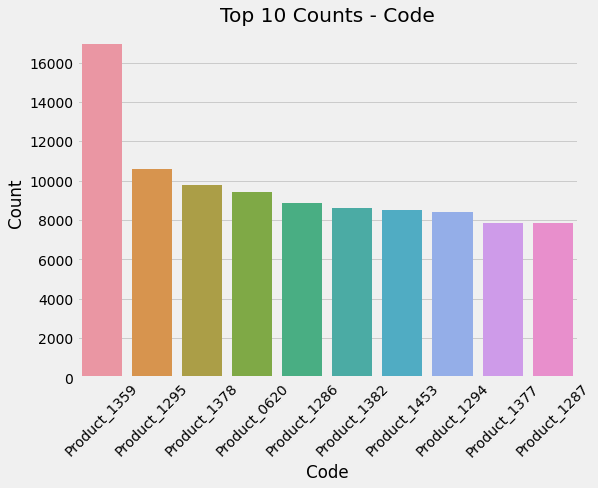

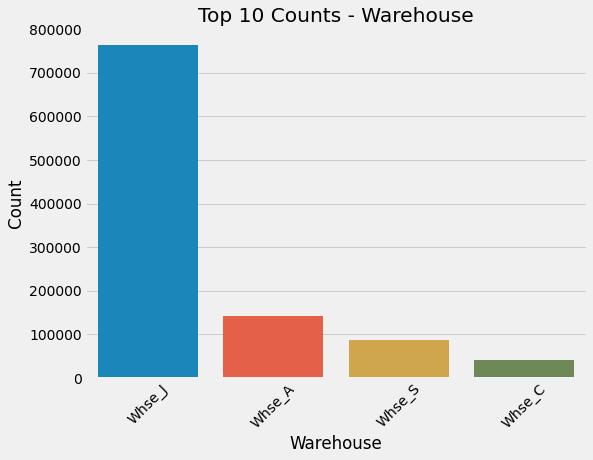

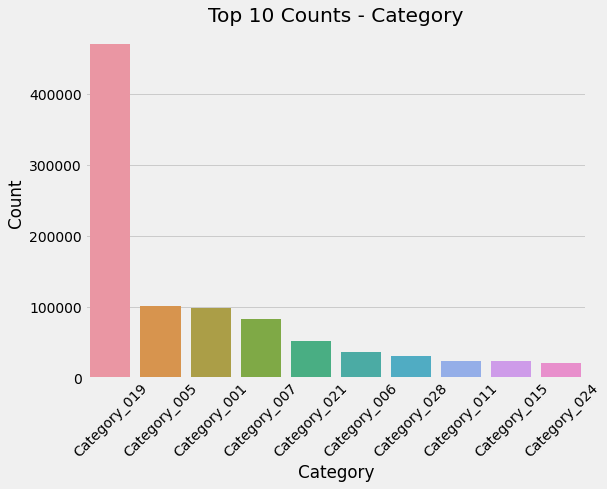

In [44]:
visualize_categorical_count(df)

In [53]:
def plot_distribution_skew(df):
    column_name = 'Demand'

    if column_name in df.columns:
        demand_data = df[column_name]
        skewness = demand_data.skew()

        if np.abs(skewness) > 0.5:
            if skewness > 0:
                skewness_label = 'right-skewed (positive skew)'
            else:
                skewness_label = 'left-skewed (negative skew)'
            print(f"The '{column_name}' column is {skewness_label} with skewness value: {skewness:.2f}")
        else:
            print(f"The '{column_name}' column is approximately symmetric with skewness value: {skewness:.2f}")

        plt.figure(figsize=(8, 6))
        sns.lineplot(data=df, x=df.index, y=column_name)
        plt.title(f"Distribution of {column_name}")
        plt.xlabel('Date')
        plt.ylabel(column_name)
        plt.show()
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")


The 'Demand' column is right-skewed (positive skew) with skewness value: 31.38


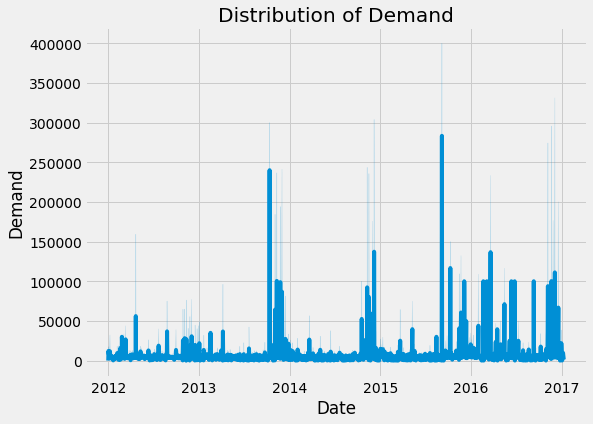

In [54]:
plot_distribution_skew(df)

In [48]:
df = df[df.index >= '2012-01-01']

In [55]:
df

,Code,Warehouse,Category,Demand
Date,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100
2012-01-19,Product_0979,Whse_J,Category_028,500
2012-02-03,Product_0979,Whse_J,Category_028,500
2012-02-09,Product_0979,Whse_J,Category_028,500
2012-03-02,Product_0979,Whse_J,Category_028,500
...,...,...,...,...
2016-04-27,Product_1791,Whse_J,Category_006,1000
2016-04-27,Product_1974,Whse_J,Category_006,1
2016-04-28,Product_1787,Whse_J,Category_006,2500


In [63]:
def plot_demand(df, category_columns):
    column_name = 'Demand'

    for category_column in category_columns:
        if category_column in df.columns:
            plt.figure(figsize=(12, 6))
            sns.barplot(data=df, x=category_column, y=column_name, estimator=sum, color='steelblue')
            sns.barplot(data=df, x=category_column, y=column_name, estimator=np.mean, color='lightblue', alpha=0.7)
            sns.barplot(data=df, x=category_column, y=column_name, estimator=np.nanmedian, color='lightgray', alpha=0.7)
            plt.title(f'Demand by {category_column}')
            plt.xlabel(category_column)
            plt.ylabel('Demand')
            plt.legend(['Total Demand', 'Mean', 'Median'])
            plt.xticks(rotation=90)
            plt.show()
        else:
            print(f"Column '{category_column}' not found in the DataFrame.")




C:\Users\Romario Mason\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\algorithms.py:98: RuntimeWarning: overflow encountered in scalar add
  boot_dist.append(f(*sample, **func_kwargs))


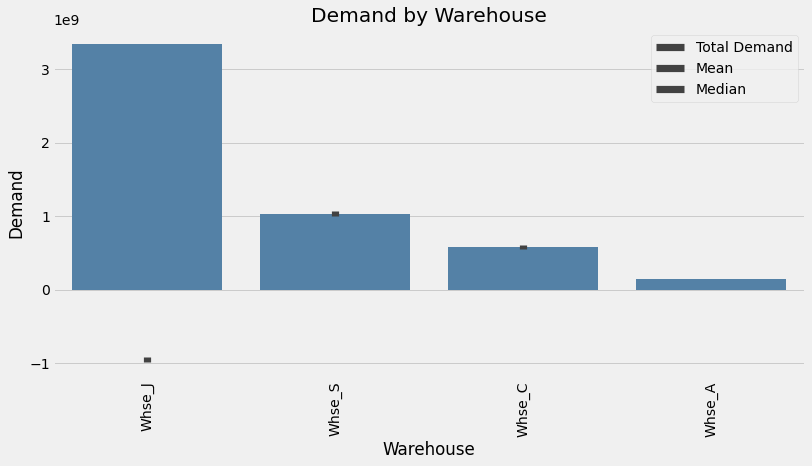

C:\Users\Romario Mason\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\seaborn\algorithms.py:98: RuntimeWarning: overflow encountered in scalar add
  boot_dist.append(f(*sample, **func_kwargs))


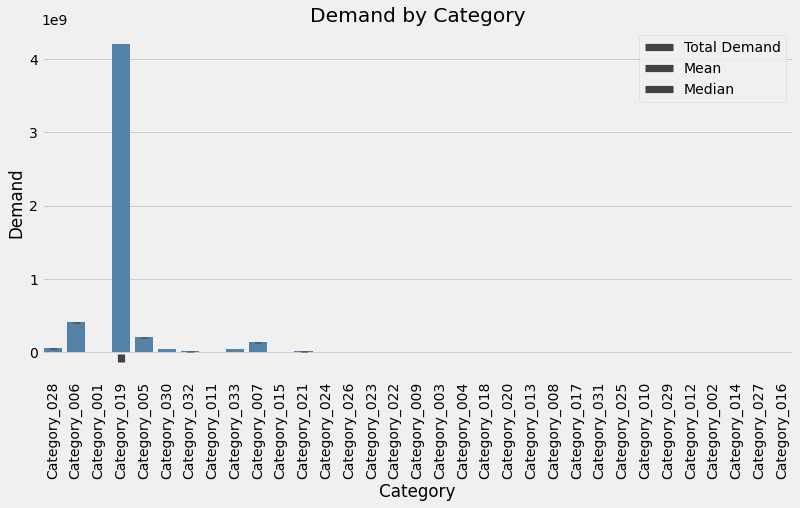

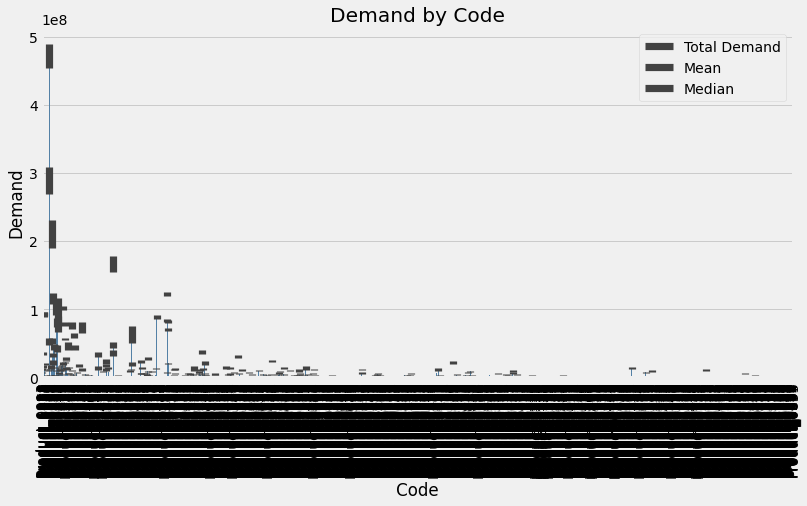

In [64]:
category_columns = ['Warehouse', 'Category', 'Code']
plot_demand(df, category_columns)

# Feature Engineering

In [65]:
def create_time_series(df):
    # Extract various time components from the date index
    df['Year'] = df.index.year
    df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['DayOfWeek'] = df.index.dayofweek
    df['WeekOfYear'] = df.index.weekofyear

    return df

In [66]:
df = create_time_series(df)
df

<ipython-input-65-d928df547316>:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['WeekOfYear'] = df.index.weekofyear


,Code,Warehouse,Category,Demand,Year,Quarter,Month,Day,DayOfWeek,WeekOfYear
Date,,,,,,,,,,
2012-07-27,Product_0993,Whse_J,Category_028,100,2012,3,7,27,4,30
2012-01-19,Product_0979,Whse_J,Category_028,500,2012,1,1,19,3,3
2012-02-03,Product_0979,Whse_J,Category_028,500,2012,1,2,3,4,5
2012-02-09,Product_0979,Whse_J,Category_028,500,2012,1,2,9,3,6
2012-03-02,Product_0979,Whse_J,Category_028,500,2012,1,3,2,4,9
...,...,...,...,...,...,...,...,...,...,...
2016-04-27,Product_1791,Whse_J,Category_006,1000,2016,2,4,27,2,17
2016-04-27,Product_1974,Whse_J,Category_006,1,2016,2,4,27,2,17
2016-04-28,Product_1787,Whse_J,Category_006,2500,2016,2,4,28,3,17


In [80]:
features = ['DayOfWeek', 'Quarter','Month', 'Year','Day','WeekOfYear']
target = ['Demand']

# Model Creation

In [76]:
train_end = '2016-01-01'
test_start = '2016-01-01'

df_train = df.loc[df.index <= train_end].copy()
df_test = df.loc[df.index > test_start].copy()

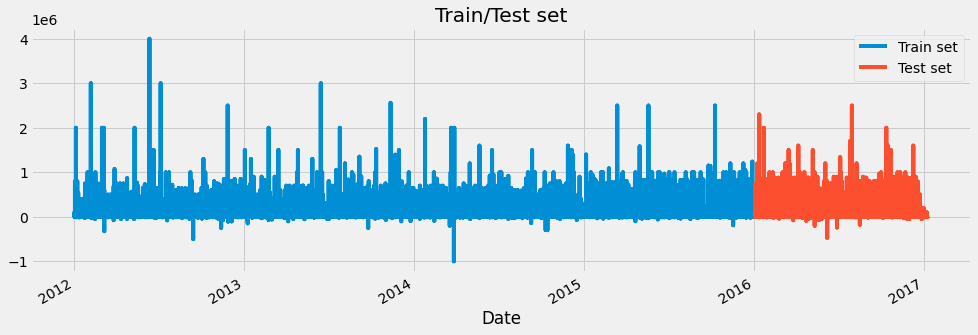

In [77]:
fig, ax = plt.subplots(figsize=(15, 5))
df_train['Demand'].plot(ax=ax, label='Train set', legend=True, title='Train/Test set')
df_test['Demand'].plot(ax=ax, label='Test set', legend=True)
plt.show()

In [81]:
#Split the data into training set and testing set 
X_train = df_train[features]
X_test = df_test[features]

y_train = df_train[target]
y_test = df_test[target]